In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from scipy import stats

In [2]:
base_path = Path.cwd().resolve()
print(base_path)

C:\Users\Matth\OneDrive\Desktop\Singlelayer_NN_Model


In [3]:
data_dir = "2020_LaserNetCSUCombinedData"
os.chdir(f'{base_path}\\{data_dir}\\SCRAM\\Code')
from import_scram import SCRAM
from simulate_scram import SCRAMTarget
os.chdir(base_path)

In [4]:
EIDlow = pd.DataFrame()
DTFlow_df = pd.DataFrame()


num_files = 65
for n in range(num_files):
    print(n)
    EIDRAW_temp = joblib.load(f'{base_path}\\rawlow\\EID_{n}.pkl')
    DTDdf_temp = joblib.load(f'{base_path}\\rawlow\\DTF_{n}.pkl')
    EIDlow = pd.concat([EIDlow,EIDRAW_temp],ignore_index=True)
    DTFlow_df = pd.concat([DTFlow_df,DTDdf_temp],ignore_index=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


In [5]:
# EIDdataraw_low = EIDdataraw_low.iloc[::8].reset_index(drop=True)
# density_temp_data_low = density_temp_data_low.iloc[::8].reset_index(drop=True)

In [5]:
EIDhigh = pd.DataFrame()
DTFhigh_df = pd.DataFrame()


num_files = 65
for n in range(num_files):
    print(n)
    EIDRAW_temp = joblib.load(f'{base_path}\\rawhigh\\EID_{n}.pkl')
    DTDdf_temp = joblib.load(f'{base_path}\\rawhigh\\DTF_{n}.pkl')
    EIDhigh = pd.concat([EIDhigh,EIDRAW_temp],ignore_index=True)
    DTFhigh_df = pd.concat([DTFhigh_df,DTDdf_temp],ignore_index=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


130000

In [11]:
EIDdataraw = pd.concat([EIDlow,EIDhigh],ignore_index=True)

In [12]:
DTDdataraw = pd.concat([DTFlow_df,DTFhigh_df],ignore_index=True)

In [13]:
classifications = pd.DataFrame(DTDdataraw.iloc[:,1]>1)

In [16]:
total_specrta = EIDdataraw.shape[0]
#Define SNV normalization and perform it on each spectra
def snv(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std_dev = np.std(data, axis=1, keepdims=True)
    return (data - mean) / std_dev

In [17]:
SNV = pd.DataFrame(np.random.uniform(0,100,size=(total_specrta, 2995)))

In [18]:
for i in range(len(EIDdataraw)):
    SNV.iloc[i,:] = snv([EIDdataraw.iloc[i,:].to_numpy().reshape(-1,1).flatten()])[0]

In [9]:
pca = PCA(n_components= 5)

In [19]:
EIDdatapca = pca.fit_transform(SNV)

In [20]:
joblib.dump(pca,f'{base_path}\\classifier\\pca.pkl')

['C:\\Users\\Matth\\OneDrive\\Desktop\\Singlelayer_NN_Model\\classifier\\pca.pkl']

In [23]:
EIDdatapca_df = pd.DataFrame(data=EIDdatapca, columns = ['PC1','PC2','PC3','PC4','PC5'])

In [24]:
classifications.columns = ['Type']
EIDdatapca_df= pd.concat([EIDdatapca_df,classifications],axis=1)

In [25]:
filtered_df = EIDdatapca_df[EIDdatapca_df['Type'] == False]

In [26]:
filtered_df1 = EIDdatapca_df[EIDdatapca_df['Type'] == 1]

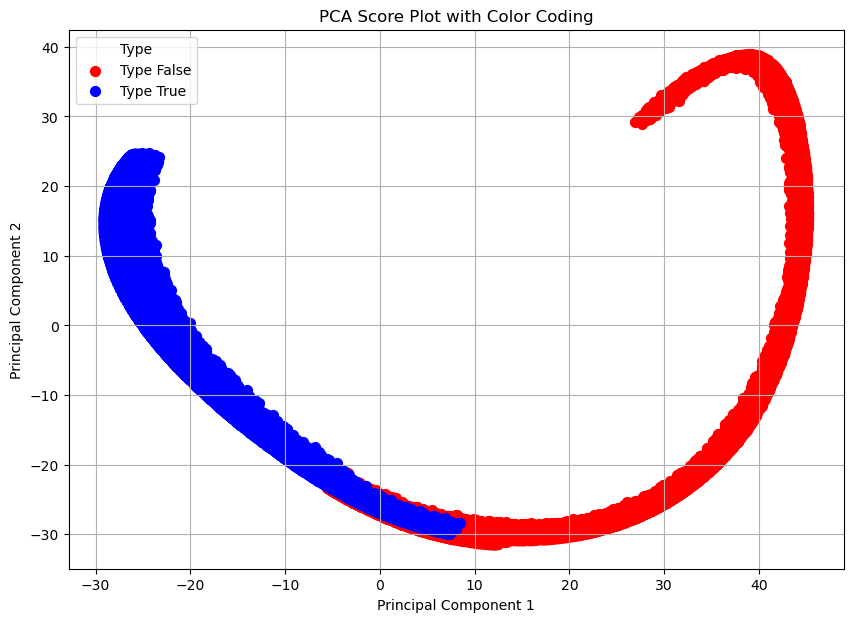

In [30]:
plt.figure(figsize=(10, 7))
colors = {0: 'red', 1: 'blue'}
for label in EIDdatapca_df['Type'].unique():
    subset = EIDdatapca_df[EIDdatapca_df['Type'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Type {label}', c=colors[label], s=50)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Score Plot with Color Coding')
plt.legend(title='Type')
plt.grid()
plt.show()

In [31]:
EIDdatapca_df

,PC1,PC2,PC3,PC4,PC5,Type
0,43.514475,32.431976,-8.039629,25.787706,-9.749436,False
1,30.825712,33.064677,33.265684,-21.760703,14.844539,False
2,43.442983,4.554560,-32.570944,0.047723,13.707799,False
3,-3.474067,-23.993332,11.187547,7.187366,-0.050287,False
4,31.769017,-23.901046,-16.651566,-13.484119,0.901075,False
...,...,...,...,...,...,...
129995,-28.256765,15.912550,-6.808750,-4.531989,-2.951285,True
129996,-27.894304,10.954852,-4.057473,0.556593,0.563622,True
129997,-28.751973,11.045692,-4.097045,-0.025025,0.331807,True
129998,-19.580836,-6.005449,7.166507,11.550870,7.935819,True


In [32]:
PCA_train, PCA_val = train_test_split(EIDdatapca_df.iloc[:,:5], test_size=0.2, random_state=42)

In [33]:
type_train, type_val = train_test_split(EIDdatapca_df.iloc[:,5], test_size=0.2, random_state=42)

In [34]:
class classifyingNN(nn.Module):
    def __init__(self):
        super(classifyingNN, self).__init__()
        self.fc1 = nn.Linear(5, 10)
        self.fc2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = classifyingNN()

In [35]:

# Initialize weights
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(weights_init)

classifyingNN(
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [37]:
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [38]:
losses = []
accuracies = []

In [39]:
X_train_tensor = torch.tensor(PCA_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(type_train.to_numpy(), dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(PCA_val.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(type_val.to_numpy(), dtype=torch.float32).unsqueeze(1)



dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

valset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(valset, batch_size=64, shuffle=False)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss

# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    for i, (inputs, targets) in enumerate(dataloader):
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            predictions = model(X_test_tensor)
            predicted_labels = (predictions > 0.5).float()
        accuracy = (predicted_labels == y_test_tensor).float().mean()
        
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
        losses.append(loss.item())
        accuracies.append(accuracy.item())
    model.eval()

# Calculate accuracy
       
        

Epoch [1/1000], Loss: 0.0549, Accuracy: 0.9770
Epoch [2/1000], Loss: 0.0394, Accuracy: 0.9797
Epoch [3/1000], Loss: 0.0347, Accuracy: 0.9811
Epoch [4/1000], Loss: 0.0313, Accuracy: 0.9824
Epoch [5/1000], Loss: 0.0287, Accuracy: 0.9832
Epoch [6/1000], Loss: 0.0273, Accuracy: 0.9843
Epoch [7/1000], Loss: 0.0263, Accuracy: 0.9850
Epoch [8/1000], Loss: 0.0256, Accuracy: 0.9857
Epoch [9/1000], Loss: 0.0255, Accuracy: 0.9865
Epoch [10/1000], Loss: 0.0255, Accuracy: 0.9873
Epoch [11/1000], Loss: 0.0245, Accuracy: 0.9876
Epoch [12/1000], Loss: 0.0227, Accuracy: 0.9879
Epoch [13/1000], Loss: 0.0223, Accuracy: 0.9883
Epoch [14/1000], Loss: 0.0215, Accuracy: 0.9885
Epoch [15/1000], Loss: 0.0205, Accuracy: 0.9884
Epoch [16/1000], Loss: 0.0200, Accuracy: 0.9886
Epoch [17/1000], Loss: 0.0198, Accuracy: 0.9887
Epoch [18/1000], Loss: 0.0194, Accuracy: 0.9888
Epoch [19/1000], Loss: 0.0193, Accuracy: 0.9889
Epoch [20/1000], Loss: 0.0194, Accuracy: 0.9892
Epoch [21/1000], Loss: 0.0195, Accuracy: 0.9893
E

KeyboardInterrupt: 

In [40]:
losses

[0.05492406710982323,
 0.039398904889822006,
 0.03473898023366928,
 0.03133561462163925,
 0.028710925951600075,
 0.027284441515803337,
 0.026259703561663628,
 0.02560773491859436,
 0.02549402415752411,
 0.025522716343402863,
 0.024483267217874527,
 0.022717412561178207,
 0.022295067086815834,
 0.021513018757104874,
 0.02053554356098175,
 0.019959520548582077,
 0.019785288721323013,
 0.019428998231887817,
 0.019345715641975403,
 0.01943017728626728,
 0.019470548257231712,
 0.019304584711790085,
 0.019338276237249374,
 0.018958106637001038,
 0.018961133435368538,
 0.01860377937555313,
 0.018313225358724594,
 0.01796058379113674,
 0.017831096425652504,
 0.017551450058817863,
 0.018132595345377922,
 0.01773361675441265,
 0.01797633245587349,
 0.01809242181479931,
 0.018080152571201324,
 0.018220866098999977,
 0.018327517434954643,
 0.018419934436678886,
 0.018363501876592636,
 0.018682779744267464,
 0.018722595646977425]

In [41]:
pd.DataFrame(accuracies)

,0
0,0.977038
1,0.979731
2,0.981077
3,0.982385
4,0.983192
5,0.984269
6,0.985038
7,0.985731
8,0.986462
9,0.987308


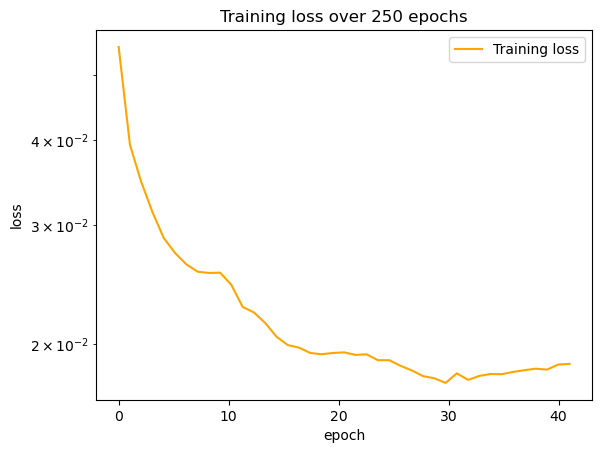

In [42]:
data = losses
x = np.linspace(0,len(losses), len(losses))
#plt.scatter(x, data, color='orange', label='val_loss_data')

plt.plot(x, data, '-',color='orange', label='Training loss')
#plt.scatter(x, data2, color='blue', label='training_loss_data')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.yscale('log')
plt.title('Training loss over 250 epochs')
plt.legend()
plt.show()
plt.close()

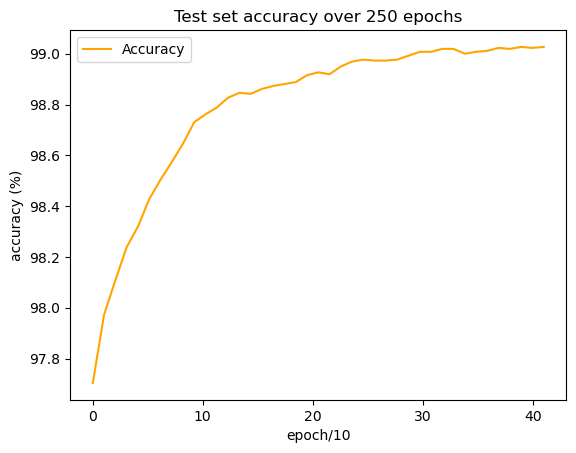

In [43]:
data = np.array(accuracies)*100
x = np.linspace(0,len(accuracies), len(accuracies))
#plt.scatter(x, data, color='orange', label='val_loss_data')

plt.plot(x, data, '-',color='orange', label='Accuracy')
#plt.scatter(x, data2, color='blue', label='training_loss_data')
plt.xlabel('epoch/10')
plt.ylabel('accuracy (%)')
plt.title('Test set accuracy over 250 epochs')

plt.legend()
plt.show()
plt.close()

In [43]:
joblib.dump(accuracies, 'accuracies')
joblib.dump(losses, 'losses')
torch.save(model.state_dict(), f'{base_path}\\classifier_temp.pth')

In [52]:




# Constants
num_trials = 10000
dx = 0.5e-4  # Single layer of thickness 500 nm

# Initialize SCRAM and get interpolators
scram = SCRAM(f'{data_dir}/SCRAM/SCRAM.txt')
en_VH = np.linspace(8, 9.97, 2995)
en_HR = np.linspace(8, 9.97, 2995)  # Spectral range of front side von Hamos spectrometer
j, k, j_f, k_f, fh, fj = scram.get_scram_intrp(dx)

# Pre-generate random values for density, temperature, and fluorescence
densities = np.random.uniform(2.23, 18, num_trials)
temperatures = np.random.uniform(0.1, 6.4, num_trials)
fluorescences = np.random.uniform(1e-4, 1e-2, num_trials)
errors = np.random.uniform(0.0, 0.2, num_trials)

# Prepare arrays to store results
intensities = np.zeros((num_trials, len(en_VH)))
variables = np.zeros((num_trials, 3))

# Loop through each trial

for i in range(num_trials):
    dens = densities[i]
    temp = temperatures[i]
    flor = fluorescences[i]
    error = errors[i]
    target = SCRAMTarget([dens], [temp], j, k, j_f, k_f, fh, fj, en_VH, en_HR, dx)
    
        # Create SCRAM target
        # Generate test spectra
    test_VH, _ = target.model([dens], [temp], flor, 100)
        # Add noise to the spectra
    noise_VH = np.random.normal(0, error * np.std(test_VH), en_VH.shape)
        # Combine the spectra and store in arrays
    intensities[i, :len(en_VH)] = test_VH + noise_VH
    variables[i] = [dens, temp, flor]
    # Convert to DataFrame
    print(i)
energy_intensity_df = pd.DataFrame(intensities)
dens_temp_noise_df = pd.DataFrame(variables)

    # Save DataFrames





5e-05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


In [53]:
real, guess,confidence = [], [], []


for i in range(0,num_trials):

    xydfslice = energy_intensity_df.iloc[i,:]
    xydfslice = xydfslice.to_numpy()

    xydfslice = xydfslice.reshape(1, -1)
    xydfslice = snv(xydfslice)
    xydfslice = pca.transform(xydfslice)
    test_tensor = torch.tensor(xydfslice, dtype=torch.float32)
    model.eval()
    with torch.no_grad():  # Turn off gradients since we're in inference mode
        outputs = model(test_tensor)
        predicted_labels = outputs.detach().numpy()  # Convert to numpy 
        predicted = predicted_labels > 0.5
    
    
    if predicted_labels.flatten()[0] > 0.5:
        conf = predicted_labels.flatten()[0]
    else:
        conf = 1 - predicted_labels.flatten()[0]
    confidence.append(conf)
    
    real.append((dens_temp_noise_df.iloc[i,1]>1).flatten()[0])
    guess.append(predicted.flatten()[0])
    


In [54]:
table = pd.concat([pd.DataFrame(real), pd.DataFrame(guess),pd.DataFrame(confidence),dens_temp_noise_df.iloc[:,1]], axis = 1)
table.columns = ['Real', 'Guess', 'Confidence', 'Temp']

In [55]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [56]:
truth_table = table[['Real', 'Guess']]

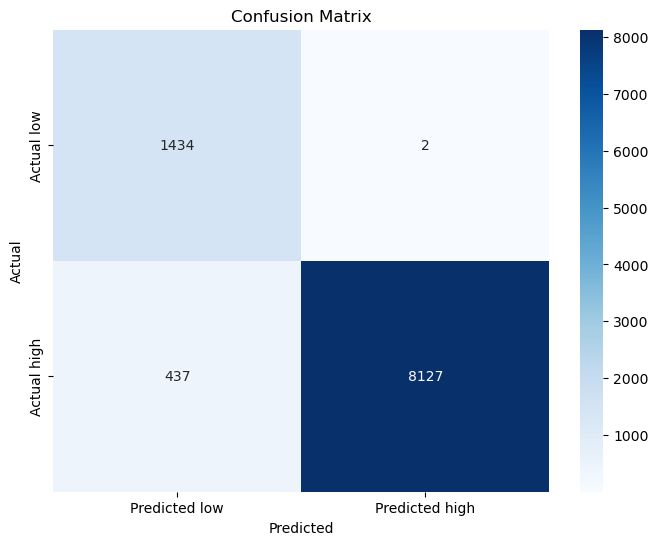

In [57]:
cm = np.array(confusion_matrix(truth_table.iloc[:,0], truth_table.iloc[:,1]))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted low', 'Predicted high'], 
            yticklabels=['Actual low', 'Actual high'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [58]:
filtered_table = table[table['Real'] != table['Guess']]

print(filtered_table)
print(filtered_table.shape[0])

      Real  Guess  Confidence      Temp
22    True  False    0.936683  1.165257
84    True  False    0.721292  1.214872
90    True  False    0.990711  1.593728
240   True  False    0.995037  1.361423
262   True  False    0.999956  1.066300
...    ...    ...         ...       ...
9936  True  False    0.543164  1.168303
9956  True  False    0.683720  1.057687
9978  True  False    0.643137  1.334310
9988  True  False    0.797676  1.045112
9993  True  False    0.997839  1.395070

[439 rows x 4 columns]
439


In [59]:
filtered_table

,Real,Guess,Confidence,Temp
22,True,False,0.936683,1.165257
84,True,False,0.721292,1.214872
90,True,False,0.990711,1.593728
240,True,False,0.995037,1.361423
262,True,False,0.999956,1.066300
...,...,...,...,...
9936,True,False,0.543164,1.168303
9956,True,False,0.683720,1.057687
9978,True,False,0.643137,1.334310
9988,True,False,0.797676,1.045112


In [60]:
torch.save(model.state_dict(), f'{base_path}\\models\\classifier.pth')
